<a href="https://colab.research.google.com/github/OurCultureBangkit/machine_learning/blob/main/ourculture_model/ourCulture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os
import matplotlib.pyplot as plt
from keras.models import Model
from keras.applications.inception_v3 import InceptionV3

In [ ]:
pip install split-folders[full]

In [ ]:
import splitfolders
input_folder = '/content/drive/MyDrive/dataset'

splitfolders.ratio(input_folder, output='ourculture',
                    seed=42, ratio=(.8, .2),
                    group_prefix=None)

Copying files: 2012 files [02:15, 14.90 files/s]


In [ ]:
train_dir = '/content/ourculture/train'
val_dir = '/content/ourculture/val'

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=30,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(150,150),
                                                    class_mode='categorical')
valid_generator = val_datagen.flow_from_directory(val_dir,
                                                  target_size=(150,150),
                                                  class_mode='categorical')

Found 1609 images belonging to 22 classes.
Found 403 images belonging to 22 classes.


In [ ]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(150,150,3))
for layer in base_model.layers:
  layer.trainable=False

87910968/87910968 [==============================] - 0s 0us/step


In [ ]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 74, 74, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 74, 74, 32)           96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 74, 74, 32)           0         ['batch_normalizati

In [ ]:
last_layer = base_model.get_layer('mixed7')

In [ ]:
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(last_layer.output)
x = tf.keras.layers.MaxPooling2D(2,2)(x)
x = tf.keras.layers.Conv2D(64, (2, 2), activation='relu')(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(22, activation='softmax')(x)

model = Model(base_model.input, x)

In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 74, 74, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 74, 74, 32)           96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 74, 74, 32)           0         ['batch_normalization[0]

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_generator, epochs=50, validation_data=valid_generator)

Epoch 1/50
51/51 [==============================] - 74s 1s/step - loss: 2.0840 - accuracy: 0.3182 - val_loss: 1.0445 - val_accuracy: 0.5931
Epoch 2/50
51/51 [==============================] - 51s 1s/step - loss: 0.9965 - accuracy: 0.6277 - val_loss: 0.7716 - val_accuracy: 0.7146
Epoch 3/50
51/51 [==============================] - 50s 982ms/step - loss: 0.7071 - accuracy: 0.7228 - val_loss: 0.5384 - val_accuracy: 0.8040
Epoch 4/50
51/51 [==============================] - 51s 994ms/step - loss: 0.5253 - accuracy: 0.7949 - val_loss: 0.5033 - val_accuracy: 0.8288
Epoch 5/50
51/51 [==============================] - 52s 987ms/step - loss: 0.4552 - accuracy: 0.8303 - val_loss: 0.4432 - val_accuracy: 0.8462
Epoch 6/50
51/51 [==============================] - 51s 1s/step - loss: 0.3858 - accuracy: 0.8533 - val_loss: 0.5571 - val_accuracy: 0.8610
Epoch 7/50
51/51 [==============================] - 50s 981ms/step - loss: 0.3569 - accuracy: 0.8676 - val_loss: 0.3959 - val_accuracy: 0.8734
Epoch 8/

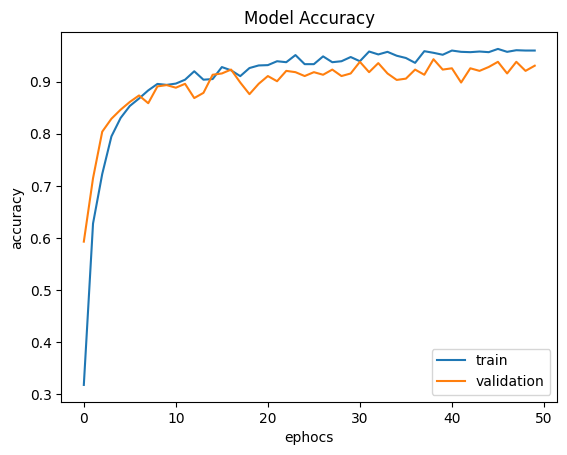

In [ ]:
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('ephocs')
  plt.legend(['train', 'validation'])
  plt.show()

In [ ]:
!mkdir -p ourCulture_model
model.save('ourCulture_model/model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
ourculture_model = "saved_model"

In [ ]:
tf.saved_model.save(model, ourculture_model)

In [ ]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model(ourculture_model)

converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model = converter.convert()

# Save the model.
with open('ourCulture_model/model.tflite', 'wb') as f:
  f.write(tflite_model)

In [ ]:
!zip -r /content/ourCulture_model.zip /content/ourCulture_model

  adding: content/ourCulture_model/ (stored 0%)
  adding: content/ourCulture_model/model.h5 (deflated 9%)
  adding: content/ourCulture_model/model.tflite (deflated 17%)


In [ ]:
from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array

classes = ['Angkep Pala', 'Badong', 'Badong Kulit', 'Gelang Kana Kulit', 'Mask Bujuh', 'Mask Dalem', 'Mask Keras', 'Mask Penasar', 'Mask Sidakarya', 'Mask Tua', 'Mask Wijil',
           'Wayang Arjuna', 'Wayang Bagong', 'Wayang Bathara Surya', 'Wayang Bathara Wisnu', 'Wayang Gareng', 'Wayang Nakula', 'Wayang Petruk', 'Wayang Sadewa', 'Wayang Semar', 'Wayang Werkudara', 'Wayang Yudistira']

uploaded = files.upload()

for fn in uploaded.keys():

  # predicting images
  path = fn
  img = load_img(path, target_size=(150, 150))
  x = img_to_array(img) / 255.0
  x = np.expand_dims(x, axis=0)

  output = model.predict(x)
  best_index = np.argmax(output)
  print(fn)
  print(output)
  print(classes[best_index])

Saving WhatsApp Image 2023-11-29 at 22.28.56_29119f9b.jpg to WhatsApp Image 2023-11-29 at 22.28.56_29119f9b.jpg
1/1 [==============================] - 6s 6s/step
WhatsApp Image 2023-11-29 at 22.28.56_29119f9b.jpg
[[5.4804059e-07 7.6867900e-06 6.4048662e-11 1.4134341e-07 1.6632022e-09
  9.6324243e-08 6.2110572e-10 2.1908121e-10 1.5219903e-05 9.9997365e-01
  9.8148547e-09 4.5607366e-13 2.5745337e-06 2.8684065e-12 4.4976790e-11
  1.3505461e-11 9.7355723e-10 1.3366620e-10 2.2498617e-13 8.0941556e-09
  1.1448646e-12 1.5944980e-11]]
Mask Tua


In [ ]:
for labels in classes:
  print(labels)

Angkep Pala
Badong
Badong Kulit
Gelang Kana Kulit
Mask Bujuh
Mask Dalem
Mask Keras
Mask Penasar
Mask Sidakarya
Mask Tua
Mask Wijil
Wayang Arjuna
Wayang Bagong
Wayang Bathara Surya
Wayang Bathara Wisnu
Wayang Gareng
Wayang Nakula
Wayang Petruk
Wayang Sadewa
Wayang Semar
Wayang Werkudara
Wayang Yudistira
